# Project 2: Logistic Regression

## Import module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from numpy import loadtxt
import pickle
import xgboost



## I. Read data

In [191]:
data = np.loadtxt('train.csv', dtype=np.uint8, delimiter=',', skiprows=1)
X = data[:, 1:]                    
Y = data[:, 0]

## II. Data overview

### II.1 Số mẫu và số feature

In [3]:
print('(Số mẫu, số thuộc tính) =', X.shape)

(Số mẫu, số thuộc tính) = (27000, 784)


## III.2 Kiểm tra mẫu trùng

In [4]:
assert np.unique(X, axis=0).shape == X.shape

### II.3 Các lớp trong tập dữ liệu

In [5]:
# truyền interpolation_ khác None để hiện ảnh nét hơn
# https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html

def display_all_labels(pics, labels, interpolation_=None):
    plt.figure(figsize=(20,12))
    for i in range(0, 25):
        if i == 9: continue
        idx = np.where(labels[:] == i)[0][0] # first index of label i
        plt.subplot(5, 5, i + 1)
        plt.imshow(pics[idx, :].reshape((28, 28)), cmap='gray', vmin=0, vmax=255, 
                   interpolation=interpolation_)
        plt.axis('off')

In [6]:
all_labels = np.unique(Y)
print('Tên lớp:', all_labels)

Tên lớp: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


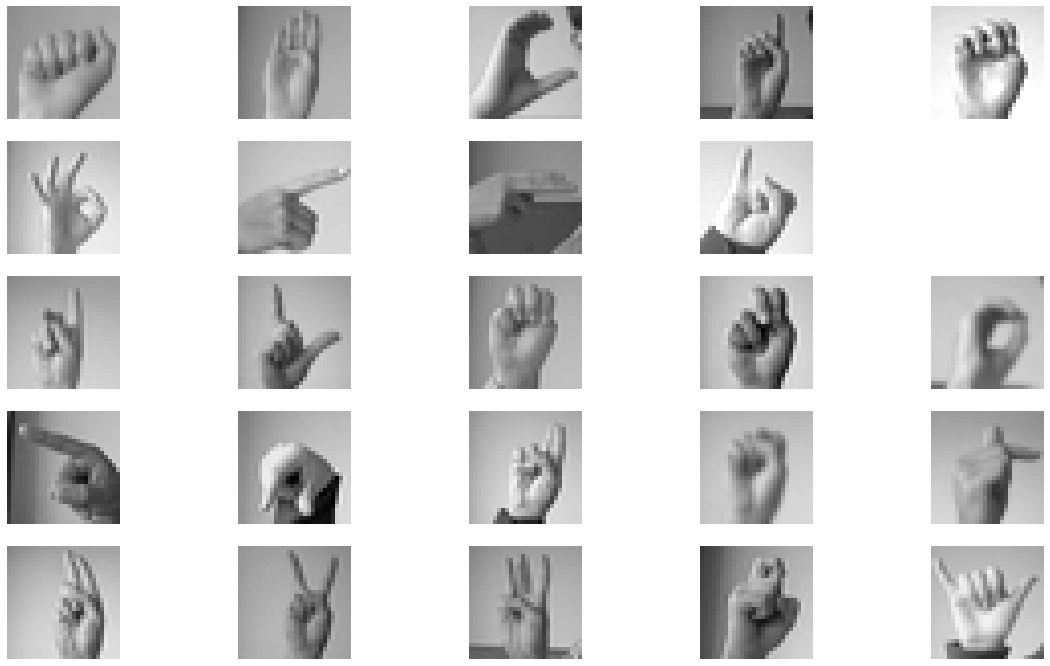

In [7]:
display_all_labels(X, Y)

#### Nhận xét:
Không có 9 và 25

## III. Data analysis

### III.1 Hình 'trung bình' của từng mẫu

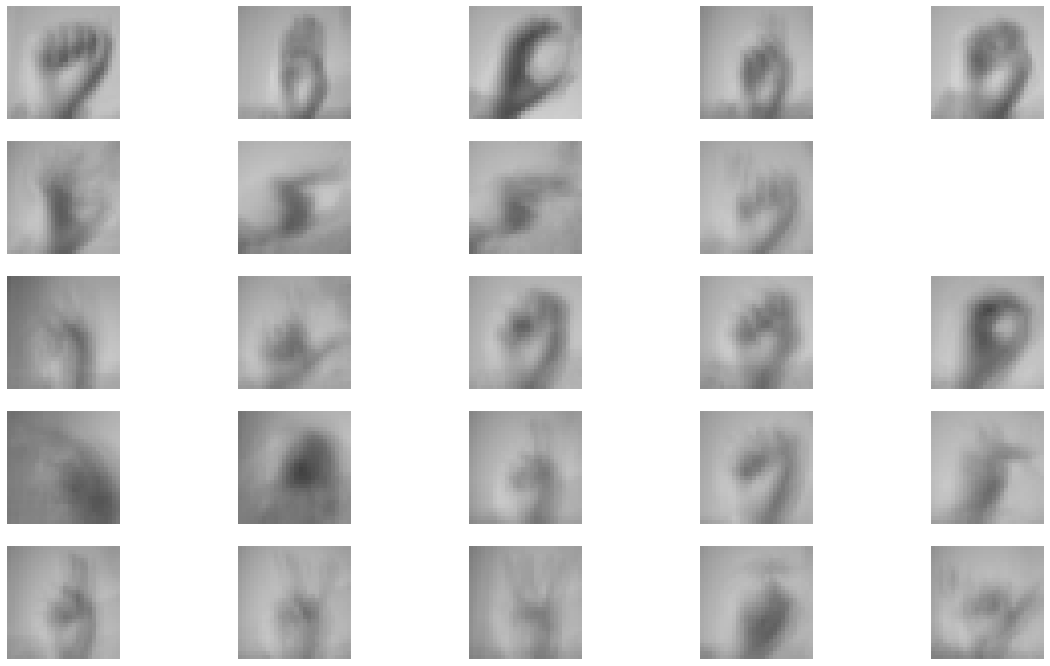

In [8]:
avg_data = np.array([np.mean(data[Y == label, :], axis=0) for label in all_labels])

display_all_labels(avg_data[:, 1:], avg_data[:, 0])

### Số mẫu của từng label

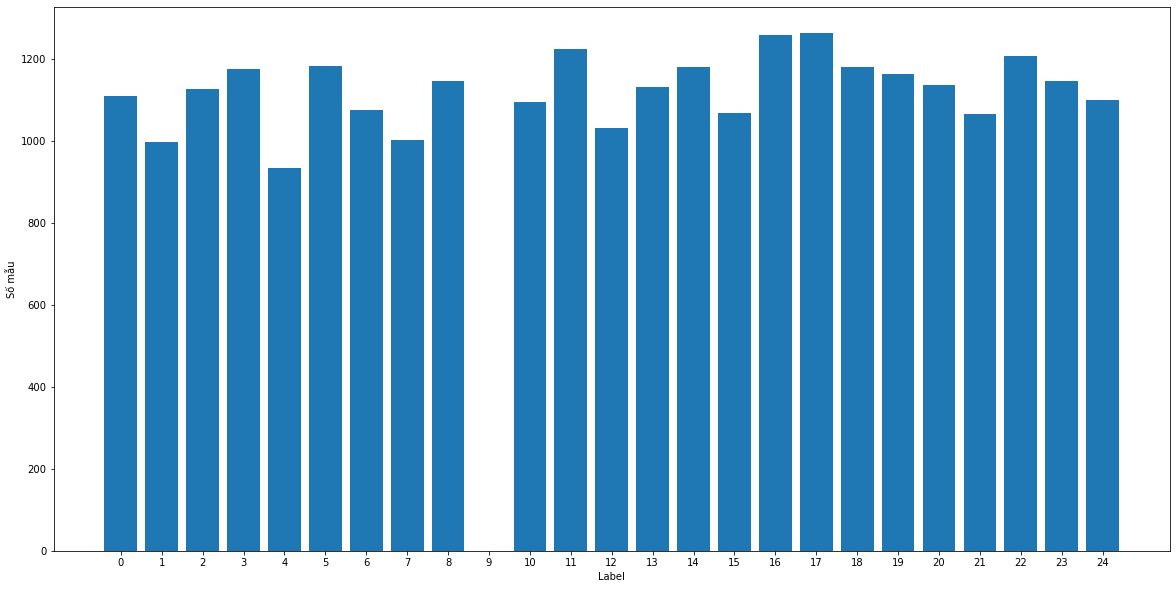

In [9]:
plt.figure(figsize=(20,10))
n = np.max(all_labels) + 1
plt.bar(range(n), [np.sum(Y == label) for label in range(n)], tick_label=range(n))
plt.xlabel('Label')
plt.ylabel('Số mẫu');

### Độ sáng trung bình của từng label

/home/alylinux/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alylinux/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


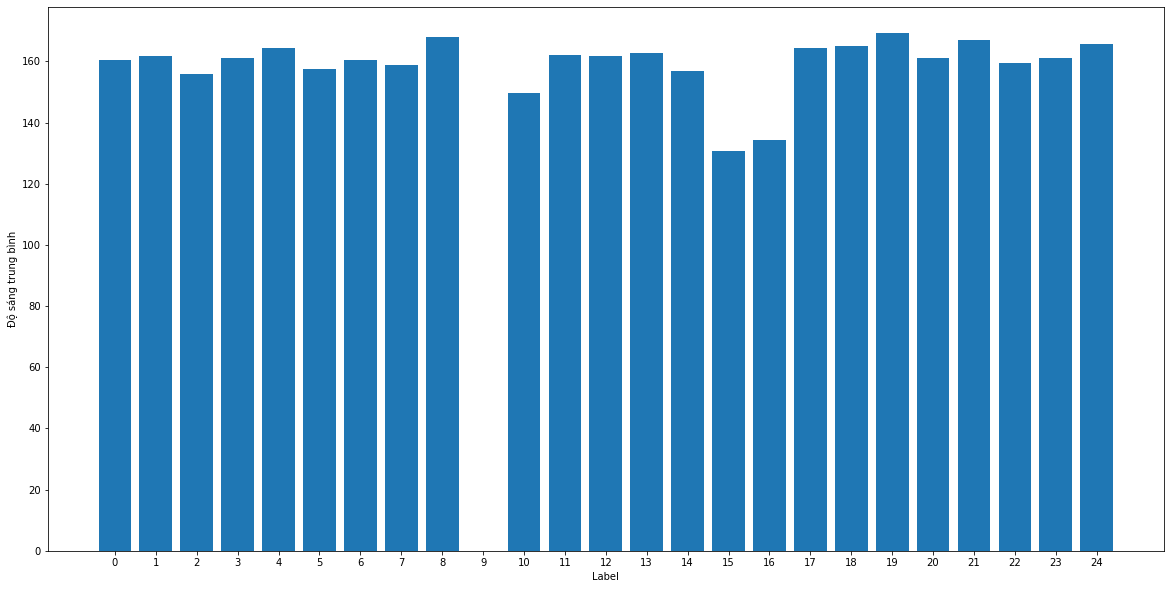

In [10]:
plt.figure(figsize=(20,10))
n = np.max(all_labels) + 1
plt.bar(range(n), [np.mean(data[Y == label, :]) for label in range(n)], tick_label=range(n))
plt.xlabel('Label')
plt.ylabel('Độ sáng trung bình');

### Gộp các hình cùng label

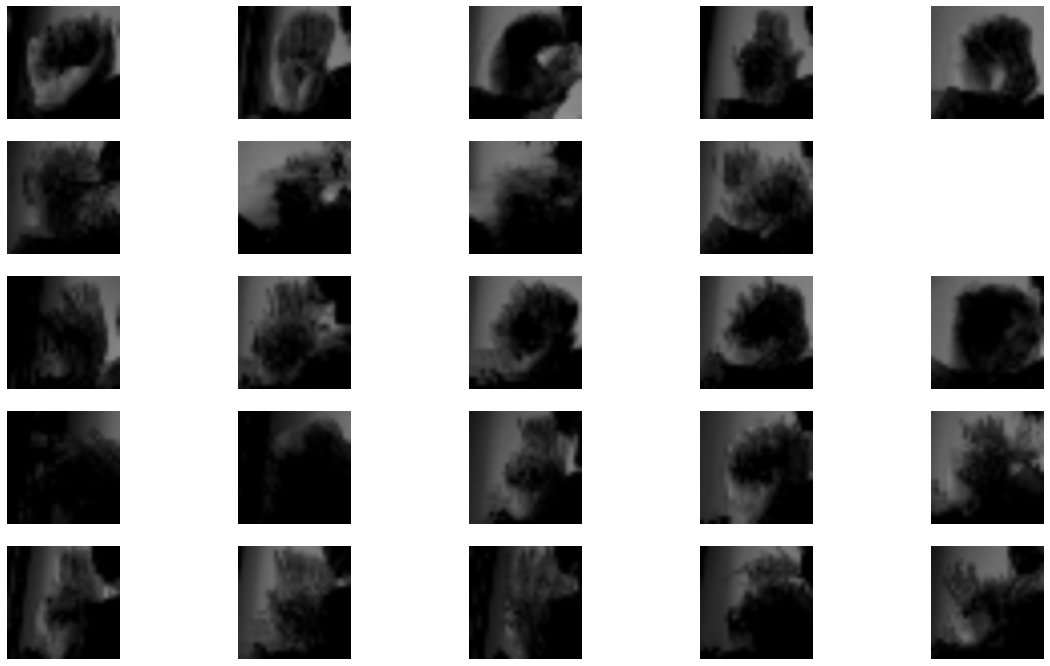

In [11]:
merge_data = np.array([np.min(data[Y == label, :], axis=0) for label in all_labels])

display_all_labels(merge_data[:, 1:], merge_data[:, 0], interpolation_='gaussian')

### Histogram động sáng trung bình của từng label

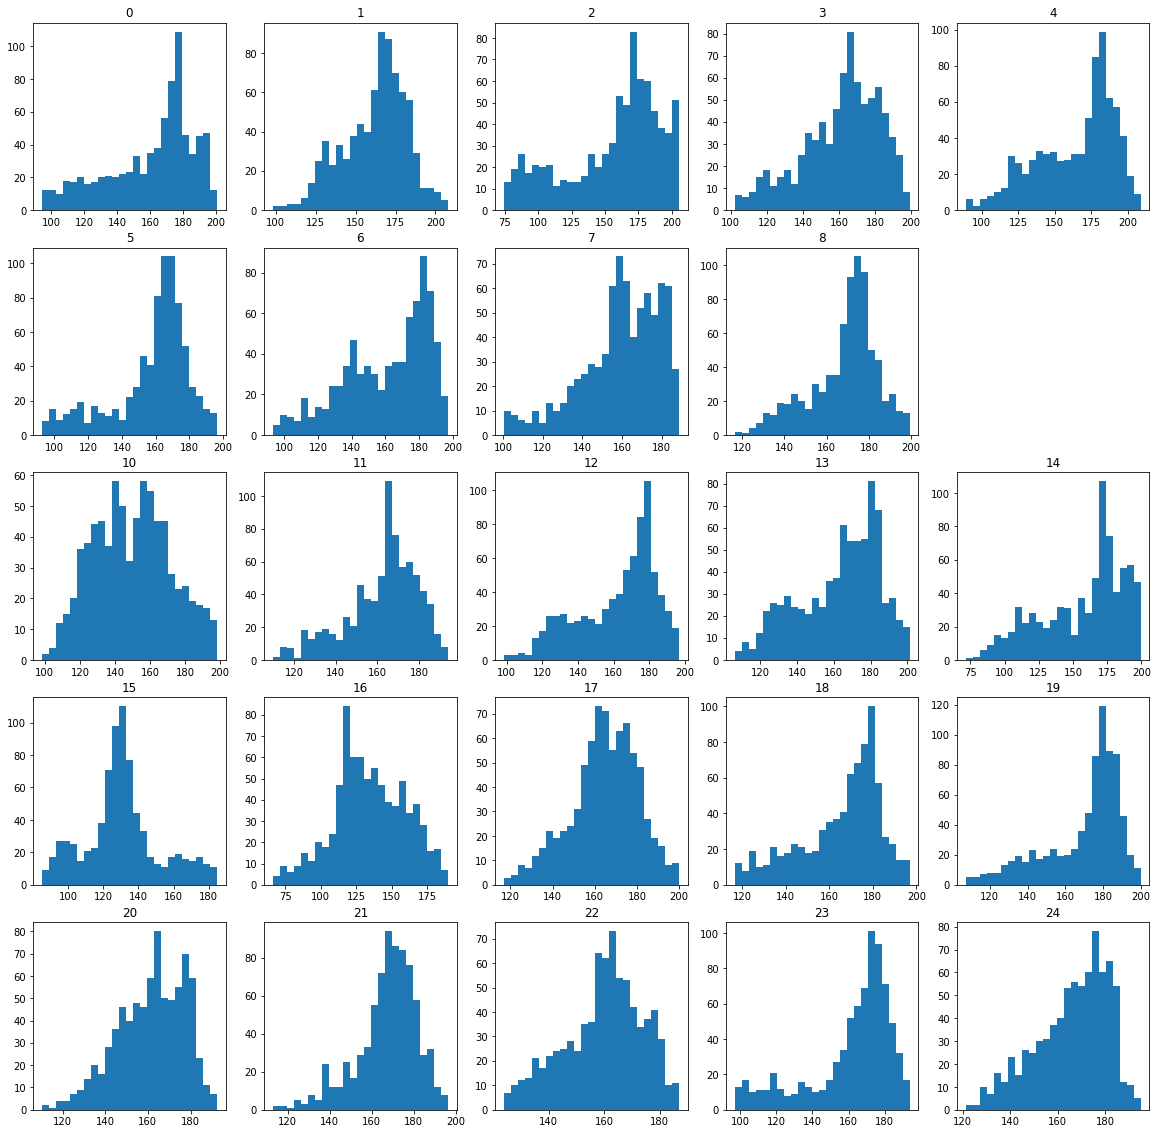

In [12]:
plt.figure(figsize=(20,20))
for i in range(0, 25):
    if i == 9: continue
    plt.subplot(5, 5, i + 1)
    plt.hist(avg_data[i if i < 9 else i  - 1, 1:], bins=25)
    plt.title(i)

## IV Mô hình

In [189]:
X = X / 255

In [174]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.001)

### IV.1 Baseline

Mô hình Logistic Regression của sklearn với dữ liệu thô

In [15]:
#baseline = LogisticRegression(tol=0.01, solver='saga')
#baseline.fit(X_train, Y_train)
#baseline.score(X_valid, Y_valid)

### IV.2 Model 1

Giảm phân giải của hình từ 28x28 thành 7x7 (cứ 4x4 pixel ở hình cũ được tính trung bình và gộp thành 1 pixel) sau đó dùng PolynomialFeatures (x1, x2, ..., xn) -> (1, x1, x2, ... xn, x1x1, x1x2, x1x3, ..., ... xnxn)

In [16]:
def model1_data_transform(X):
    Z = np.zeros((len(X), 7*7))
    for k, row in enumerate(X):
        pic = row.reshape(28,28)
        new_row = np.zeros(7*7)
        for i in range(7):
            for j in range(7):
                new_row[i*7 + j] = np.mean(pic[i*4:(i+1)*4, j*4:(j+1)*4])
        Z[k] = new_row
        
  #  poly = PolynomialFeatures(2)
  #  Z = poly.fit_transform(Z)
    
   # return Z[:, 1:]
    return Z

In [17]:
#model1 = LogisticRegression(tol=0.0001, solver='saga', n_jobs=-1, max_iter=500000)
#model1.fit(model1_data_transform(X_train), Y_train)
#model1.score(model1_data_transform(X_valid), Y_valid)

In [175]:
model = xgboost.XGBClassifier(learning_rate = 0.30012,n_estimators=200)

In [176]:
x_train = model1_data_transform(X_train)[:,7:-7]
x_valid = model1_data_transform(X_valid)[:,7:-7]

In [178]:
model.fit(x_train, Y_train,eval_set = [(x_train,Y_train),(x_valid,Y_valid)],eval_metric="mlogloss")

[0]	validation_0-mlogloss:1.86228	validation_1-mlogloss:1.84665
[1]	validation_0-mlogloss:1.49715	validation_1-mlogloss:1.41115
[2]	validation_0-mlogloss:1.24480	validation_1-mlogloss:1.16444
[3]	validation_0-mlogloss:1.05610	validation_1-mlogloss:1.00538
[4]	validation_0-mlogloss:0.90766	validation_1-mlogloss:0.91222
[5]	validation_0-mlogloss:0.79181	validation_1-mlogloss:0.80250
[6]	validation_0-mlogloss:0.69219	validation_1-mlogloss:0.68969
[7]	validation_0-mlogloss:0.61099	validation_1-mlogloss:0.61509
[8]	validation_0-mlogloss:0.54417	validation_1-mlogloss:0.54864
[9]	validation_0-mlogloss:0.48579	validation_1-mlogloss:0.51285
[10]	validation_0-mlogloss:0.43500	validation_1-mlogloss:0.47054
[11]	validation_0-mlogloss:0.39213	validation_1-mlogloss:0.43615
[12]	validation_0-mlogloss:0.35301	validation_1-mlogloss:0.40063
[13]	validation_0-mlogloss:0.31876	validation_1-mlogloss:0.37013
[14]	validation_0-mlogloss:0.28730	validation_1-mlogloss:0.36470
[15]	validation_0-mlogloss:0.26023	

[126]	validation_0-mlogloss:0.00352	validation_1-mlogloss:0.08300
[127]	validation_0-mlogloss:0.00347	validation_1-mlogloss:0.08314
[128]	validation_0-mlogloss:0.00343	validation_1-mlogloss:0.08382
[129]	validation_0-mlogloss:0.00338	validation_1-mlogloss:0.08442
[130]	validation_0-mlogloss:0.00334	validation_1-mlogloss:0.08393
[131]	validation_0-mlogloss:0.00331	validation_1-mlogloss:0.08286
[132]	validation_0-mlogloss:0.00327	validation_1-mlogloss:0.08135
[133]	validation_0-mlogloss:0.00323	validation_1-mlogloss:0.08087
[134]	validation_0-mlogloss:0.00319	validation_1-mlogloss:0.08148
[135]	validation_0-mlogloss:0.00316	validation_1-mlogloss:0.08050
[136]	validation_0-mlogloss:0.00313	validation_1-mlogloss:0.07943
[137]	validation_0-mlogloss:0.00309	validation_1-mlogloss:0.07891
[138]	validation_0-mlogloss:0.00306	validation_1-mlogloss:0.07830
[139]	validation_0-mlogloss:0.00303	validation_1-mlogloss:0.07758
[140]	validation_0-mlogloss:0.00300	validation_1-mlogloss:0.07689
[141]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.30012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
pickle.dump(model, open("pima.pickle.dat", "wb"))

### IV.3 Model 2

In [ ]:
# code

### Từ đây trở xuống để test
(xoá khi hoàn thành)

In [32]:
test = np.loadtxt('sign_mnist_test.csv', dtype=np.uint8, delimiter=',', skiprows=1)
X_test = test[:, 1:] / 255
Y_test = test[:, 0]

In [179]:
#print(baseline.score(X_test, Y_test)*100)
print(model.score(model1_data_transform(X_test)[:,7:-7], Y_test)*100)

82.43167875069716


## V. Lý thuyết

## Boosting là gì?
#### Ý tưởng:
Thay vì xây dựng một mô hình dự đoán (chẳng hạn descision tree) có độ chính xác tương đối, ta đi xây dựng nhiều mô hình dự đoán có độ chính xác kém hơn (weak learner) khi đi riêng lẻ nhưng lại cho độ chính xác cao khi kết hợp lại.

Ta có thể hình dung mỗi weak learner gồm học sinh yếu, khá, giỏi và thầy giáo. Trong đó, trọng số uy tín về kiến thức của thầy giáo sẽ là cao nhất và học sinh yếu sẽ là thấp nhất. Khi bạn đặt câu hỏi nào đó và cần những người này đưa ra kết luận, nếu nhiều người cùng có chung kết luận hoặc uy tín của những người đưa ra kết luận cao hơn tập thể thì ta có thể tin kết luận này là đúng.

Ví dụ trong thuật toán AdaBoost, mỗi lần huấn luyện weak learner, mô hình sẽ tính lại trọng số cho các điểm dữ liệu đã bị phân lớp sai, để những lượt huấn luyện tiếp theo những điểm dữ liệu này sẽ có cơ hội nhiều hơn được phân lớp đúng. Dưới đây là mô hình dự đoán tổng quát:

$ H(\mathbf{x}) = sign(\alpha_1 h_1(\mathbf{x}) + \alpha_2 h_2(\mathbf{x}) + ... + \alpha_k h_k(\mathbf{x}))$

## Gradient descent là gì?

<b>Mục tiêu</b>: tìm vector các tham số sao cho tối ưu hoá hàm mục tiêu cụ thể nào đó:

$\mathbf{P^*} = argmin_\mathbf{P} \Phi(\mathbf{P})$<br>
Phương pháp Gradient descent:<br>

Gradient: $\mathbf{g}_m = \{g_{jm}\} = \{\lbrack \frac{\partial \Phi(\mathbf{P})}{\partial P_j} \rbrack_{\mathbf{P}=\mathbf{P}_{m-1}}\}$<br>
Parameters: $\mathbf{p}_m = -\rho_m \mathbf{g}_m$<br>
Learning rate: $\rho_m = argmin_\rho \Phi(\mathbf{P}_{m-1} - \rho \mathbf{g}_m)$<br>
Target parameters: $\mathbf{P^*} = \Sigma_{m=0}^M \mathbf{p}_m$<br>
Như vậy, kết quả của gradient descent là weighted combination của các gradient.

## Kết hợp hai hướng tiếp cận

Như vậy, mục tiêu của chúng ta là đi xây dựng additive model:<br>

$F(\mathbf{x};\{\beta_m, \mathbf{a}_m\}_1^M = \Sigma_{m=1}^M \beta_m h(x; \mathbf{a}_m))$<br>

Nhưng sẽ rất khó nếu ta huấn luyện trực tiếp để tìm tập parameters trong không gian tham số:<br>

$\{\beta_m, \mathbf{a}_m\}_1^M = argmin_{\{\beta_m', \mathbf{a}_m'\}}\Sigma_{i=1}^N L (y_i, \Sigma_{m=1}^M \beta_m' h(\mathbf{x}_i, \mathbf{a}_m'))$<br>

Vì vậy, ta sẽ dùng greedy-stagewise trong không gian hàm số để giải:

$(\beta_m, \mathbf{a}_m) = argmin_{\beta, a} \Sigma_{i=1}^N L(y_i, F_{m-1}(\mathbf{x}_i) + \beta h(\mathbf{x}_i;a))$<br>

khi đó,<br>

$F_m(\mathbf{x}) = F_{m-1}(\mathbf{x}) + \beta_m h(\mathbf{x};\mathbf{a}_m)$

## Thuật toán Gradient boosting tổng quát

Thuật toán này nhằm xấp xỉ gradient thông qua một hàm tham số hoá $h(\mathbf{x}; \mathbf{a}_m)$. Tại mỗi vòng lặp: ta tính gradient $\tilde{y}_m$. Ta xem$\{-\tilde{y}_i, \mathbf{x}_i\}_1^N$ là tập training để huấn luyện hàm $h(\mathbf{x}; \mathbf{a}_m)$. Từ đó, ta có thể dự đoán $-\tilde{y}_m từ \mathbf{x}$.<br>

Gradient_Boost()<br>
 &nbsp;&nbsp;&nbsp;&nbsp;
 $ F_0(\mathbf{x}) = argmin_\rho \Sigma_{i=1}^N L(y_i, \rho)$<br>
 &nbsp;&nbsp;&nbsp;&nbsp; 
 For m = 1 to M do:<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
  $\#$ gradient step<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
  $\tilde{y} = -\lbrack \frac{\partial L(y_i, F(\mathbf{x_i}))}{\partial F(\mathbf{x_i})} \rbrack_{F(\mathbf{x}) = F_{m-1}(\mathbf{x})}, i = 1, N$<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
  $a_m = argmin_{a, \beta} \Sigma_{i=1}^N \lbrack \tilde{y} - \beta h(x_i; a) \rbrack$<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
  $\#$ boosting step<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
  $\rho_m = argmin_\rho \Sigma_{i=1}^N L(y_i, F_{m-1}(x_i) + \rho h(x_i; \mathbf{a_m})$<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
  $F_m(\mathbf{x}) = F_{m-1}(\mathbf{x}) + \rho_m h(x; \mathbf{a_m})$<br>
 &nbsp;&nbsp;&nbsp;&nbsp;endFor<br>
endAlgorithm<br>

Như vậy, $\tilde{y}_i$ vừa là gradient của function space vừa là label của parameter space. $\beta$ là leanring rate để tìm tham số $\mathbf{a}_m$ và $\rho_m$ là learning rate để boosting additive model $F_m(\mathbf{x})$.

Từ thuật toán cơ sở này, ta có thể mở rộng cho các mô hình khác thông qua loss function được định nghĩa trước.

# XGBoost <br>
<div >
Đặt:

$n$: số lượng mẫu huấn luyện.<br>
$m$: số lượng features.<br>
$\mathcal{D} = \{(\mathbf{x}_i, y_i)\} $ là tập dữ liệu với $|\mathcal{D}| = n,\mathbf{x}_i \in \mathbb{R}^m, y_i \in \mathbb{R}$.<br>
$q$: cấu trúc của một cây, ánh xạ mẫu dữ liệu vào nút lá tương ứng.<br>
$T$: số lượng nút lá trên cây.<br>
$f_k$: cấu trúc các cây $k$ độc lập của mô hình.<br>
$L$ : Hàm mất mát (loss function)<br>
$w_i$: trọng số của nút lá thứ $i$.<br>
$\hat{y}_i^{(t)}$: giá trị dự đoán của instance thứ $i$ tại vòng lặp thứ $t$.<br>
$f_t^2(\mathbf{x}_i)$: đạo hàm bậc 2 của hàm $f$.<br>
$I_j = \{i|q(\mathbf{x}_i) = j\}$: tập các giá trị tại nút lá $j$<br>
$I_L$: tập giá trị nút lá bên trái.<br>
$I_R$: tập giá trị nút lá bên phải.<br>
$I = I_L \cup I_R$.<br>
    </div>

### Ý tưởng đằng sau mô hình:

Giả sử chúng ta có cây $K$, mô hình là:<br>
    $\Sigma_{k=1}^K f_k$<br>
Trong đó $f_k$ là một dự đoán từ một cây quyết định.<br>
Cho nên có thể thấy mô hình thực chất là một tập các cây quyết định

<div >
    <b>Mô hình học:</b><br>

<p style="text-align:center">$\hat{y}_i = \phi(\mathbf{x}_i) = \Sigma_{k=1}^K f_k(\mathbf{x}_i), f_k \in \mathcal{F}$.<br></p>
Trong đó:<br> 
    <ul>
        <li>$\mathbf{x}_i$ là vector đặc trưng cho điểm dữ liệu thứ $i$ </li>
    <li>$\mathcal{F} = \{f(\mathbf{x}) = w_{q(\mathbf{x})}\} (q : \mathbb{R}^m) \rightarrow T, w \in \mathbb{R}^T$.<br></li>
    </ul>

</div>

###     <b>Hàm học:</b><br>

Để train mô hình, chúng ta cần tối ưu một hàm mất mát (loss function).
Thông thường chúng ta sẽ sử dụng:
<ul>
    <li>
        Rooted Mean Squared Error cho hồi quy(regression)<br>
    $L = \frac{1}{N} \Sigma_{i=1}^N (y_i - \hat{y}_i)^2   $
    </li>
    <li>LogLoss cho binary classification<br>
    $L = - \frac{1}{N} \Sigma_{i=1}^N (y_i\log(p_i) + (1-y_i)\log(1- p_i)   $
    </li>
    <li>mlogloss cho multi-classification<br>
    $L = - \frac{1}{N} \Sigma_{i=1}^N \Sigma_{j=1}^M (y_{i,j}\log(p_{i,j})    $
    </li>
    </ul>

Chính quy hóa (Regularization) là một phần quan trọng khác của mô hình.<br>
Một công thức chính quy hoá tốt kiểm soát mức độ phức tạp của mô hình, ngăn cản việc bị overfitting<br>
<i>Định nghĩa hàm mất mát trong mô hình:</i>

<p style = "text-align:center">$\Omega = \gamma T + \frac{1}{2} \lambda \Sigma_{j=1}^T w_j^2$
</p>

Kết hợp hàm mất mát với hàm chính quy hóa ta được đối tượng của mô hình

<p style = "text-align:center">$Obj = \mathcal{L}(\phi) = L + \Omega$</p>

<div >
Vậy ta có hàm học tổng quát cho mô hình như sau:<br>

<p style = "text-align:center">$\mathcal{L}(\phi) = \Sigma_i l(\hat{y}_i, y_i) + \Sigma_k \Omega(f_k)$ </p>
  Trong đó,<br>
    <ul>
        <li>$\Omega(f) = \gamma T + \frac{1}{2} \lambda |w|^2$</li>
        <li>$ \Sigma_i l(\hat{y}_i, y_i)$ là hàm mất mát tùy thuộc từng mô hình</li>
    </ul>


</div>

Trong XGBoost, chúng ta sử dụng gradient descent để tối ưu Objective(mục tiêu)<br>
Cho trước một objective $Obj(y,\hat y)$ để tối ưu, gradient descent là một kỹ thuật lặp đi lặp lại để tính:<br>
<p style = "text-align:center"> $\partial_{\hat{y}} Obj(y,\hat{y})$ </p>
tại mỗi lần lặp. Sau đó chúng ta cải thiện $\hat{y}$ dọc theo hướng của gradient để giảm thiểu objective

### Tiến trình học:
Đối với thuật toán lặp, chúng ta có thể xác định lại hàm mục tiêu là
<p >$Obj^{(t)} = \Sigma_{i=1}^N L(y_i, \hat{y}_i^{(t)}) + \Sigma_{i=1}^t \Omega(f_i)$ <br>
$= \Sigma_{i=1}^N L(y_i, \hat{y}_i^{(t-1)} + f_t(\mathbf{x}_i)) + \Sigma_{i=1}^t \Omega(f_i)$</p>


 Để tối ưu hóa nó bằng gradient descent, chúng ta cần tính toán gradient. Hiệu suất cũng có thể được cải thiện bằng cách xem xét cả gradient bậc 1 và bậc 2

$\partial_{\hat{y}^{(t)}} Obj^{(t)}$<br>
$\partial_{\hat{y}^{(t)}}^{2} Obj^{(t)}$<br>

Vì chúng ta không có đạo hàm cho mọi hàm mục tiêu, chúng ta sẽ tính toán xấp xỉ taylor bậc hai của nó

$Obj^{(t)} \sim \Sigma_{i=1}^N \lbrack L(y_i, \hat{y}^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i) \rbrack + \Sigma_{i=1}^t\Omega(f_i)$ <br>

với,<br>
<ul>
    <li>$g_i = \partial_{\hat{y}^{(t-1)}} l(y_i, \hat{y}^{(t-1)})$</li> 
    <li> $h_i = \partial_{\hat{y}^{(t-1)}}^2 l(y_i, \hat{y}^{(t-1)}).$</li>
    </ul><br>
Loại hằng số, ta có:<br>
$Obj^{(t)} = \Sigma_{i=1}^n \lbrack g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i) \rbrack + \Omega(f_t)$<br>
$Obj^{(t)} = \Sigma_{i=1}^n \lbrack g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i) \rbrack + \gamma T + \frac{1}{2} \lambda \Sigma_{j=1}^T w_j^2 $ <br>
$Obj^{(t)} = \Sigma_{j=1}^T \lbrack (\Sigma_{i \in I_j} g_i)w_j + \frac{1}{2}(\Sigma_{i \in I_j} h_i + \lambda)w_j^2 \rbrack + \gamma T.$<br>

Trọng số tối ưu tại mỗi nút lá: $w_j^* = -\frac{\Sigma_{i\in I_j} g_i}{\Sigma_{i\in I_j} h_i + \lambda}$<br>
        trong đó: $g$ và $h$ lần lượt là hàm mất mát bậc 1 và bậc 2<br>
        $\lambda $ là tham số chính quy hóa
Hàm lỗi tính trên toàn bộ cây: $Obj^{(t)} = -\frac{1}{2} \Sigma_{j=1}^T \frac{(\Sigma_{i\in I_j} g_i)^2}{\Sigma_{i \in I_j} h_i + \lambda} + \gamma T$<br>

Điều kiện rẽ nhánh:<br>

$Obj_{split}= gain = \frac{1}{2} \lbrack \frac{\Sigma_{i\in I_L} g_i)^2}{\Sigma_{i \in I_L} h_i + \lambda} + \frac{\Sigma_{i\in I_R} g_i)^2}{\Sigma_{i \in I_R} h_i + \lambda} - \frac{\Sigma_{i\in I} g_i)^2}{\Sigma_{i \in I} h_i + \lambda} \rbrack - \gamma$

# XGBClassifier

<b>class xgboost.XGBClassifier(objective='binary:logistic', **kwargs)</b>

### Một số tham số đáng chú ý trong mô hình đã sử dụng

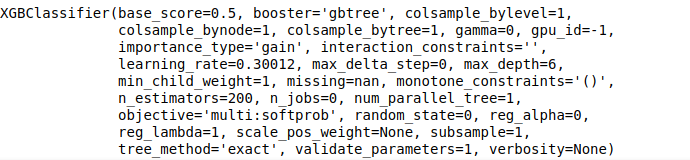

<ul>
<li>
    <b>booster (string)</b> - chỉ định bộ booster nào sẽ được sử dụng
    <ul>
        <li> <b>gbtree</b> tree-based model</li>
        <li><b>gblinear</b> linear function</li>
        <li><b>dart</b> </li>
    </ul><br>
    <b>Vì mô hình xây dựng các cây nên booster='gbtree'</b>
</li>
    <li>
    <b>objective (string)</b>
    <ul>
        <li> binary:logistic -Phục vụ cho phân lớp nhị phân sử dụng logistic </li>
        <li>multi:softprob - Phục vụ cho việc phân loại nhiều lớp (>2) </li>
        <li>...</li>
    </ul><br>
</li>
      <li>
    <b>n_estimators (int)</b> - số lần boosting
</li>
   <li>
    <b>learning_rate (float) </b> tăng tỷ lệ học tập
    
   </li>
      <li>
    <b>max_depth (int) </b> độ sâu tối đa cho base learners
   
</li>    
      <li>
    <b>base_score  </b> Điểm dự đoán ban đầu của tất cả các trường hợp, độ lệch toàn cục.
   
</li>    
    <li>
    <b>importance_type (string, default "gain")  </b> Loại feature importance cho thuộc tính feature_importances_
   <ul>
        <li> gain</li>
        <li>weight</li>
        <li>cover</li>
       <li>total_cover</li>
       <li>total_gain</li>
    </ul><br>
</li>    
    </ul>

<b>XGBoost</b> và <b>Gradient boosting </b> đều dựa trên cùng ý tưởng đó là boosting thông qua gradient descent trong không gian hàm số. Tuy nhiên, điều làm nên hiệu suất ấn tượng và khả năng tính toán của XGBoost nằm ở ba yếu tố:
<ul>
<li>Engineering để tránh overfitting như: sub-sampling row, column, column per split levels, áp dụng regularized L1 và L2.</li>
<li>Khả năng tận dụng tài nguyên hệ thống: tính toán song song trên CPU/GPU, tính toán phân tán trên nhiều server, tính toán khi tài nguyên bị giới hạn, cache optimization để tăng tốc training.</li>
<li>Và cuối cùng là khả năng xử lý missing data value, tiếp tục training bằng mô hình đã được build trước đó để tiết kiệm thời gian.</li>
    </ul